In [1]:
# imports and loading
import scipy
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pymodulon.io import *
from os import path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import numpy as np
import math

standardize_by_sample = True
pentose_phosphate_pathway = 'map00030'
genes = [
    'ZMO2_RS05625', 'ZMO2_RS05645', 'ZMO2_RS05650', 'ZMO2_RS05815', 'ZMO2_RS05810',
]

xylose_genes_df = pd.read_csv('../Zymomonas_mobilis/2032_output/log_tpm.csv', index_col = 0)
expression_df = pd.read_csv('../data/processed_data/log_tpm.csv', index_col = 0)
expression_df = pd.concat([expression_df, xylose_genes_df.loc[genes]]).fillna(0)

interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))
proteomics_df = pd.read_excel('../data/external/proteomics_10_3389_fmicb_2019_02596.XLSX', sheet_name = 'LFQ', index_col = 0)
metab_df = pd.read_excel('../data/external/metabolomics_10_3389_fmicb_2019_02596.XLSX', index_col = 0)
metab_df = metab_df.set_index('Metabolite').drop(columns = 'DCW = dry cell weight').fillna(0)

# mid-glucose (T1, about 50% glucose utilized)
# late glucose (T2, about 5–10 g glucose/L remaining)
# early xylose (T3, ∼1 h after glucose was completely depleted)
# late xylose (T4, ∼24 h after glucose was completely depleted)
# let's focus on SynH3- samples, as I'm not particularlly interested in stressors
column_to_sample = {
    'LDI_early_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_early',
    'LDI_late_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_mid',
    'LDI_early_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_late',
    'LDI_late_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_stat',
    'no_LDI_early_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_early',
    'no_LDI_late_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_mid',
    'no_LDI_early_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_late',
    'no_LDI_late_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_stat',
}

sample_X_df = pd.DataFrame(index = expression_df.index)
for group_id, group_df in ica_data.sample_table.groupby('full_name'):
    sample_X_df[group_id] = expression_df[group_df.index].T.mean()


###############################
# modify proteomics dataframe #
###############################
col_opts = ['SynH3- T1', 'SynH3- T2', 'SynH3- T3', 'SynH3- T4', 
            'SynH3 T1', 'SynH3 T2', 'SynH3 T3', 'SynH3 T4'
            ]
control_cols = ['SynH3- T1', 'SynH3 T1']
opt_to_name = {
    'SynH3- T1' : 'LDI_early_glucose',
    'SynH3- T2' : 'LDI_late_glucose',
    'SynH3- T3' : 'LDI_early_xylose',
    'SynH3- T4' : 'LDI_late_xylose', 
    'SynH3 T1' : 'no_LDI_early_glucose',
    'SynH3 T2' : 'no_LDI_late_glucose',
    'SynH3 T3' : 'no_LDI_early_xylose',
    'SynH3 T4' : 'no_LDI_late_xylose',
}

# find overlap between ICA genes and proteomics data
#proteomics_df = proteomics_df.loc[genes]
if standardize_by_sample:
    proteomics_df = proteomics_df  / proteomics_df.sum() # standardize by sample

# let's create the standards
col_to_std = {}
col_to_cols = {}
proteome_fold_change_df = pd.DataFrame(index = proteomics_df.index)
proteome_amt_change_df = pd.DataFrame(index = proteomics_df.index)
proteome_p_value_df = pd.DataFrame(index = proteomics_df.index)
for col in control_cols:
    cols_use = [col+' Rep1', col+' Rep2', col+' Rep3']
    meaned_df = proteomics_df[cols_use].mean(axis = 1)
    col_to_std.update({col.split(' ')[0] : meaned_df})
    col_to_cols.update({col.split(' ')[0] : cols_use})
for col in col_opts:
    control = col.split(' ')[0]
    cols_use = [col+' Rep1', col+' Rep2', col+' Rep3']
    meaned_df = proteomics_df[cols_use].mean(axis = 1)
    fold_change = (meaned_df / col_to_std[control])
    proteome_fold_change_df[opt_to_name[col]] = np.log2(fold_change)
    proteome_amt_change_df[opt_to_name[col]] = meaned_df - col_to_std[control]
    _, pvalues = scipy.stats.ttest_ind(proteomics_df[cols_use].T, proteomics_df[col_to_cols[control]].T)
    proteome_p_value_df[opt_to_name[col]] = np.log10(pvalues)
flipped_proteome_p_value_df = proteome_p_value_df * -1 * np.sign(proteome_fold_change_df)


#################################
# modify metabolomics dataframe #
#################################
# metabolites data processing
code_to_df_name = {
    'g6p_c' : 'Glucose 6-phosphate',
    '6pgc_c' : '6-phosphogluconate', 
    'f6p_c' : 'Fructose 6-phosphate',
    'xu5p__D_c' : 'Xylulose 5-phosphate',
    'r5p_c' : 'Ribose 5-phosphate', 
    'ru5p__D_c' : 'Ribulose 5-phosphate',
    's7p_c' : 'Sedoheptulose 7-phosphate',
    'e4p_c' : 'Erythrose 4-phosphate',
    'g3p_c' : 'Glycerol 3-phosphate', 
}
external = [
    'Glucose',
    'Xylose'
]

# let's pull out xylose processing genes
metabs = list(code_to_df_name.values())
col_opts = ['SynH-LDI T1', 'SynH-LDI T2', 'SynH-LDI T3', 'SynH-LDI T4', 
            'SynH+LDI T1', 'SynH+LDI T2', 'SynH+LDI T3', 'SynH+LDI T4'
            ]
control_cols = ['SynH-LDI T1', 'SynH+LDI T1']
opt_to_name = {
    'SynH-LDI T1' : 'LDI_early_glucose',
    'SynH-LDI T2' : 'LDI_late_glucose',
    'SynH-LDI T3' : 'LDI_early_xylose',
    'SynH-LDI T4' : 'LDI_late_xylose', 
    'SynH+LDI T1' : 'no_LDI_early_glucose',
    'SynH+LDI T2' : 'no_LDI_late_glucose',
    'SynH+LDI T3' : 'no_LDI_early_xylose',
    'SynH+LDI T4' : 'no_LDI_late_xylose',
}

# find overlap between ICA genes and proteomics data
if standardize_by_sample:
    metab_df = metab_df  / metab_df.sum() # standardize by sample

# let's create the standards
col_to_std = {}
col_to_cols = {}
metab_fold_change_df = pd.DataFrame(index = metab_df.index)
metab_p_value_df = pd.DataFrame(index = metab_df.index)
for col in control_cols:
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    meaned_df = metab_df[cols_use].mean(axis = 1)
    col_to_std.update({col.split(' ')[0] : meaned_df})
    col_to_cols.update({col.split(' ')[0] : cols_use})
for col in col_opts:
    control = col.split(' ')[0]
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    meaned_df = metab_df[cols_use].mean(axis = 1)
    fold_change = (meaned_df / col_to_std[control])
    metab_fold_change_df[opt_to_name[col]] = np.log2(fold_change)
    _, pvalues = scipy.stats.ttest_ind(metab_df[cols_use].T, metab_df[col_to_cols[control]].T)
    metab_p_value_df[opt_to_name[col]] = np.log10(pvalues)
flipped_metab_p_value_df = metab_p_value_df * -1 * np.sign(metab_fold_change_df)

####################################
# modify transcriptomics dataframe #
####################################
old_to_new = {index : row['full_name']+'_r'+str(row['rep_id']) for index, row in ica_data.sample_table.iterrows()}
df = expression_df.rename(columns = old_to_new)
keep = []
for col in df:
    if 'lignocellulose_ferment' in col:
        keep.append(col)
expr_df = df[keep]
old_to_new = {}
for col in expr_df.columns:
    new = ''
    if 'high_ACSH' in col:
        new += 'SynH+LDI '
    elif 'low_ACSH' in col:
        new += 'SynH-LDI '
    
    if 'early' in col:
        new += 'T1 '
    elif 'mid' in col:
        new += 'T2 '
    elif 'late' in col:
        new += 'T3 '
    elif 'stat' in col:
        new += 'T4 '

    new += 'rep'+col.split('_r')[1][0]
    old_to_new.update({col : new})
expr_df = expr_df.rename(columns = old_to_new)
expr_df = 2**expr_df # unlog it

# let's pull out xylose processing genes
metabs = list(code_to_df_name.values())
col_opts = ['SynH-LDI T1', 'SynH-LDI T2', 'SynH-LDI T3', 'SynH-LDI T4', 
            'SynH+LDI T1', 'SynH+LDI T2', 'SynH+LDI T3', 'SynH+LDI T4'
            ]
control_cols = ['SynH-LDI T1', 'SynH+LDI T1']
opt_to_name = {
    'SynH-LDI T1' : 'LDI_early_glucose',
    'SynH-LDI T2' : 'LDI_late_glucose',
    'SynH-LDI T3' : 'LDI_early_xylose',
    'SynH-LDI T4' : 'LDI_late_xylose', 
    'SynH+LDI T1' : 'no_LDI_early_glucose',
    'SynH+LDI T2' : 'no_LDI_late_glucose',
    'SynH+LDI T3' : 'no_LDI_early_xylose',
    'SynH+LDI T4' : 'no_LDI_late_xylose',
}

# find overlap between ICA genes and proteomics data
if standardize_by_sample:
    expr_df = expr_df  / expr_df.sum() # standardize by sample

# let's create the standards
col_to_std = {}
col_to_cols = {}
expr_fold_change_df = pd.DataFrame(index = expr_df.index)
expr_p_value_df = pd.DataFrame(index = expr_df.index)
for col in control_cols:
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    cols_use = list(set(cols_use).intersection(expr_df.columns))
    meaned_df = expr_df[cols_use].mean(axis = 1)
    col_to_std.update({col.split(' ')[0] : meaned_df})
    col_to_cols.update({col.split(' ')[0] : cols_use})
for col in col_opts:
    control = col.split(' ')[0]
    cols_use = [col+' rep1', col+' rep2', col+' rep3']
    cols_use = list(set(cols_use).intersection(expr_df.columns))
    meaned_df = expr_df[cols_use].mean(axis = 1)
    fold_change = (meaned_df / col_to_std[control])
    expr_fold_change_df[opt_to_name[col]] = np.log2(fold_change)
    _, pvalues = scipy.stats.ttest_ind(expr_df[cols_use].T, expr_df[col_to_cols[control]].T)
    expr_p_value_df[opt_to_name[col]] = np.log10(pvalues)
# let's correct p_values to be negative when fold_change is negative
flipped_expr_p_value_df = expr_p_value_df * -1 * np.sign(expr_fold_change_df)

# volcano plots

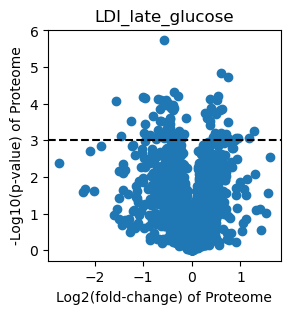

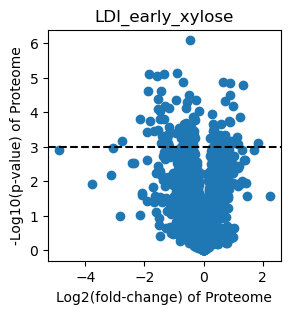

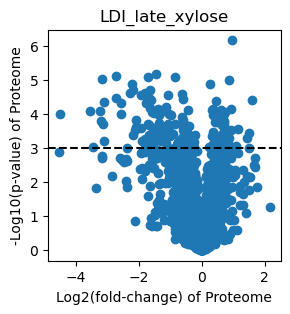

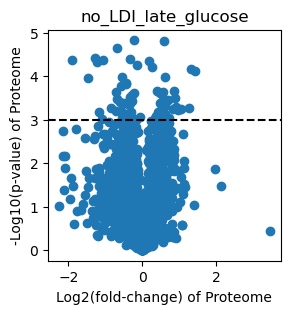

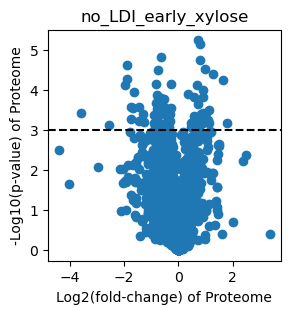

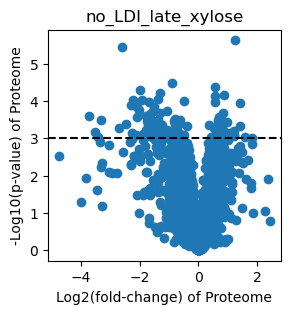

In [8]:
# settings
fold_change_df = proteome_fold_change_df
p_value_df = proteome_p_value_df

for col in fold_change_df:
    if 'early_glucose' in col:
        continue
    plt.figure(figsize = (3, 3))
    plt.scatter(fold_change_df[col], -p_value_df[col.replace('fold_change', 'p_value')])
    plt.axhline(y = -np.log10(.001), c = 'k', ls = '--')
    
    plt.title(col)
    plt.xlabel('Log2(fold-change) of Proteome')
    plt.ylabel('-Log10(p-value) of Proteome')
    plt.show()

# proteome panel of PPP genes

In [3]:
# options
nitrogen_genes = [
    'ZCP4_1183', 'ZCP4_0790', 'ZCP4_0614', 'ZCP4_0397', 
    'ZCP4_0127', 'ZCP4_1693', 'ZCP4_1508', 'ZCP4_1358', 
    'ZCP4_1350', 'ZCP4_0924'
]
# pulled by looking at KEGG maps mostly
PPP_genes = [
    'ZCP4_0122', 'ZCP4_1667', 'ZCP4_1066', 'ZCP4_1199', 
    'ZCP4_0134', 'ZCP4_1069', 'ZCP4_0905', 
    'ZMO2_RS05625', 'ZMO2_RS05645', 'ZMO2_RS05650', 'ZMO2_RS05815', 'ZMO2_RS05810',
]
xylose_to_g3p_genes = [
    'ZCP4_1069', 'ZCP4_0134', 'ZCP4_1066', 'ZCP4_0801', 
]
regulatory_genes = [
    'ZCP4_1362'
]

gene_to_label = {
    'ZCP4_0122' : 'glucose-6p to fructose-6p',
    'ZCP4_1667' : 'frutose-6p to frutcose-1,6p AND \n glucono-1,5-lactone-6p to gluconolactone-6p',
    'ZCP4_1066' : 'frutcose-1,6p to g3p',
    'ZCP4_1199' : 'xylulose-5p to ribulose-5p',
    'ZCP4_0134' : 'ribulose-5p to ribose-5p',
    'ZCP4_1069' : 'ribose-5p to g3p',
    'ZCP4_0905' : 'glucose-6p to glucono-1,5-lactone-6p', # the pathway from this to D-ribulose seems to be lacking in Zymomonas, I'm guessing this won't run much in xylose

    'ZMO2_RS05625' : 'xylose to xylulose', # xylA
    'ZMO2_RS05645' : 'xylose to xylulose', # xylA
    'ZMO2_RS05650' : 'xylulose to xylulose-5p', # xylB
    'ZMO2_RS05815' : 'erythrose-4p and xylulose-5p to g3p and fructose-6p', # tktA
    'ZMO2_RS05810' : 'sedoheptulose-7p + g3p to fructose-6p + erythrose-4p', # talB, fructose-6p should really be β-D-fructofuranose 6-phosphate, but escher has it as fructose-6p

    'ZCP4_1362' : 'nifA, nif-specific regulator of nitrogen fixation',
}

conversion = {
    'ZMO2_RS05625' : 'b3565', # xylA
    'ZMO2_RS05645' : 'b3565', # xylA
    'ZMO2_RS05650' : 'b3564', # xylB
    'ZMO2_RS05815' : 'b2935', # tktA
    'ZMO2_RS05810' : 'b0008', # talB
}

conversion_2 = {
    'LDI_early_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_early', 
    'LDI_late_glucose_fold_change' : 'lignocellulose_ferment:high_ACSH_mid', 
    'LDI_early_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_late', 
    'LDI_late_xylose_fold_change' : 'lignocellulose_ferment:high_ACSH_stat',
    'no_LDI_early_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_early', 
    'no_LDI_late_glucose_fold_change' : 'lignocellulose_ferment:low_ACSH_mid', 
    'no_LDI_early_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_late', 
    'no_LDI_late_xylose_fold_change' : 'lignocellulose_ferment:low_ACSH_stat',
}

## version 1 - proteome and transcriptome being axes

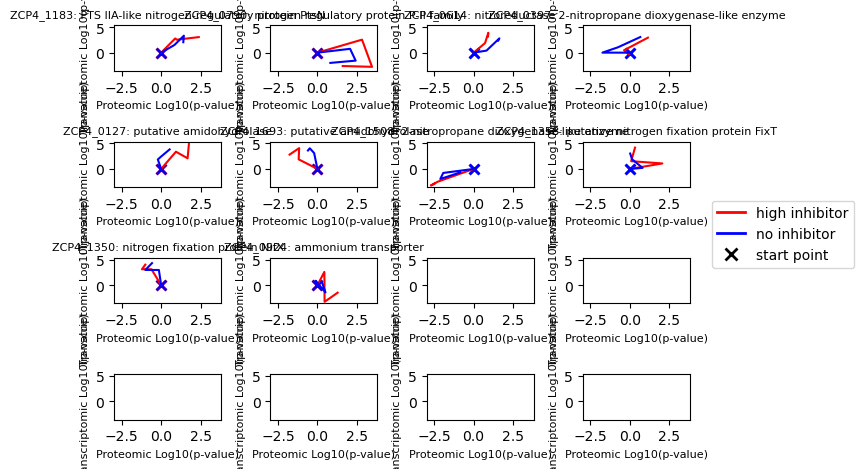

In [4]:
# settings
plot_genes = nitrogen_genes
prot_changes_df = flipped_proteome_p_value_df
gene_changes_df = flipped_expr_p_value_df

size = math.ceil(len(plot_genes)**.5)
fig, axs = plt.subplots(size,size)
ax_iter = iter(axs.flatten())
max_x = 0
min_x = 0
max_y = 0
min_y = 0
for gene in plot_genes:
    ax = next(ax_iter)
    # let's look at expression, iM activity, and proteomics of the genes in question
    #prot_index = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
    gene_changes = gene_changes_df.loc[gene]
    #if gene in ica_data.gene_table.index:
        #prot_changes = np.log2(ica_data.gene_table.loc[gene][column_to_sample.keys()].astype(float).rename(index = column_to_sample))
    #else:
    if gene in conversion:
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[conversion[gene]]
    else:
        ZM_gene = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[ZM_gene]

    order_1 = [
        'LDI_early_glucose', 
        'LDI_late_glucose', 
        'LDI_early_xylose', 
        'LDI_late_xylose', 
    ]
    order_2 = [
        'no_LDI_early_glucose', 
        'no_LDI_late_glucose', 
        'no_LDI_early_xylose', 
        'no_LDI_late_xylose', 
    ]
    
    if gene in gene_to_label:
        label = gene_to_label[gene]
    else:
        label = gene+': '+ica_data.gene_table.loc[gene].gene_product
    ax.set_title(label, fontsize = 8)
    ax.scatter(prot_changes.loc[order_1][0], gene_changes.loc[order_1][0], c = 'red', marker = 'x', lw = 2, s = 50)
    ax.scatter(prot_changes.loc[order_2][0], gene_changes.loc[order_2][0], c = 'blue', marker = 'x', lw = 2, s = 50)
    ax.plot(prot_changes.loc[order_1], gene_changes.loc[order_1], c = 'red', label = 'high_ACSH')
    ax.plot(prot_changes.loc[order_2], gene_changes.loc[order_2], c = 'blue', label = 'low_ACSH')
    if min(prot_changes.loc[order_1+order_2]) < min_x:
        min_x = min(prot_changes.loc[order_1+order_2])
    if max(prot_changes.loc[order_1+order_2]) > max_x:
        max_x = max(prot_changes.loc[order_1+order_2])
    if min(gene_changes.loc[order_1+order_2]) < min_y:
        min_y = min(gene_changes.loc[order_1+order_2])
    if max(gene_changes.loc[order_1+order_2]) > max_y:
        max_y = max(gene_changes.loc[order_1+order_2])
for ax in axs.flatten():
    ax.set_xlim([1.1*min_x, 1.1*max_x])
    ax.set_ylim([1.1*min_y, 1.1*max_y])
    ax.set_xlabel('Proteomic Log10(p-value)', fontsize = 8)
    ax.set_ylabel('Transcriptomic Log10(p-value)', fontsize = 8)

# Create custom legend elements using Line2D and Patch
legend_handles = [
    Line2D([0], [0], color='red', lw=2, label='high inhibitor'),
    Line2D([0], [0], color='blue', lw=2, label='no inhibitor'),
    Line2D([0], [0], color='black', lw=0, marker='x', markersize=8, markeredgewidth=2, label='start point')
]
patch = Patch(color='yellow', label='Custom Patch')  # Example of a patch in the legend

# Combine the line and patch objects into a single legend
fig.legend(handles = legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('../figures/xylose_story_panel.pdf', transparent = True)
plt.show()

# create and save legend
plt.figure()
plt.legend(handles = legend_handles, loc='center')
plt.savefig('../figures/xylose_story_panel_legend.pdf', transparent = True)
plt.close()

## version 2 - just overlay the plots

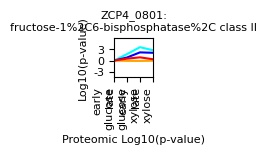

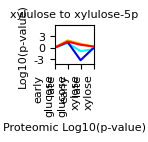

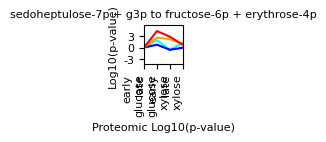

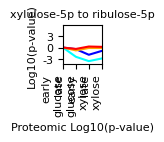

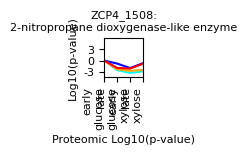

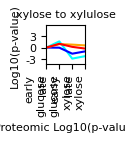

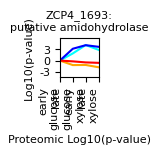

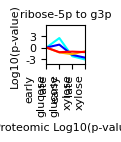

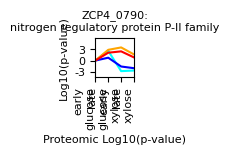

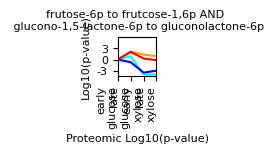

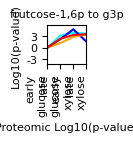

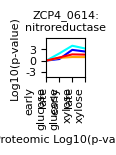

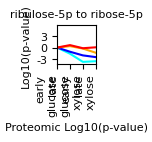

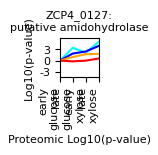

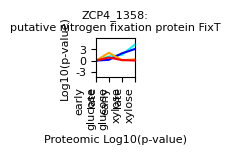

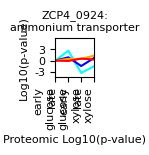

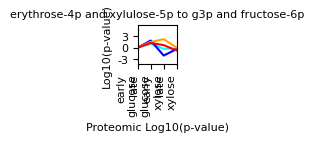

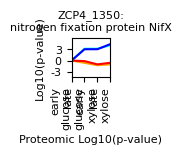

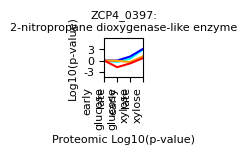

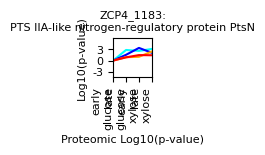

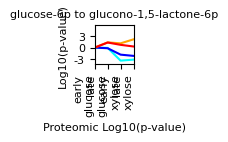

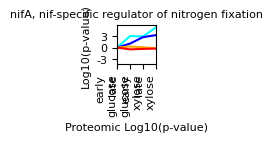

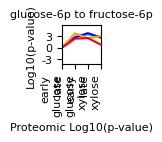

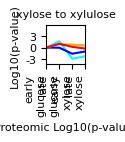

In [5]:
# settings
plot_genes = list(set(nitrogen_genes+PPP_genes+xylose_to_g3p_genes+regulatory_genes))
prot_changes_df = flipped_proteome_p_value_df
gene_changes_df = flipped_expr_p_value_df


order_1 = [
    'LDI_early_glucose', 
    'LDI_late_glucose', 
    'LDI_early_xylose', 
    'LDI_late_xylose', 
]
order_2 = [
    'no_LDI_early_glucose', 
    'no_LDI_late_glucose', 
    'no_LDI_early_xylose', 
    'no_LDI_late_xylose', 
]

# get sizing to make all equal
max_y = 0
min_y = 0
for gene in plot_genes:
    gene_changes = gene_changes_df.loc[gene]
    if gene in conversion:
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[conversion[gene]]
    else:
        ZM_gene = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[ZM_gene]

    if min(prot_changes.loc[order_1+order_2]) < min_y:
        min_y = min(prot_changes.loc[order_1+order_2])
    if max(prot_changes.loc[order_1+order_2]) > max_y:
        max_y = max(prot_changes.loc[order_1+order_2])
    if min(gene_changes.loc[order_1+order_2]) < min_y:
        min_y = min(gene_changes.loc[order_1+order_2])
    if max(gene_changes.loc[order_1+order_2]) > max_y:
        max_y = max(gene_changes.loc[order_1+order_2])
if abs(max_y) < abs(min_y):
    tick_dist = int(max_y)
else:
    tick_dist = int(min_y)
        
# plotting
for gene in plot_genes:
    #ax = next(ax_iter)
    fig, ax = plt.subplots(figsize = (0.5, 0.5))
    # let's look at expression, iM activity, and proteomics of the genes in question
    #prot_index = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
    gene_changes = gene_changes_df.loc[gene]
    #if gene in ica_data.gene_table.index:
        #prot_changes = np.log2(ica_data.gene_table.loc[gene][column_to_sample.keys()].astype(float).rename(index = column_to_sample))
    #else:
    if gene in conversion:
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[conversion[gene]]
    else:
        ZM_gene = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
        prot_changes = prot_changes_df.rename(columns = conversion_2).loc[ZM_gene]

    if gene in gene_to_label:
        label = gene_to_label[gene]
    else:
        label = gene+':\n'+ica_data.gene_table.loc[gene].gene_product
    ax.set_title(label, fontsize = 8)

    # let's plot gene changes
    ax.plot([0, 1, 2, 3], gene_changes.loc[order_1], c = 'cyan', label = 'high_ACSH_genes')
    ax.plot([0, 1, 2, 3], gene_changes.loc[order_2], c = 'blue', label = 'low_ACSH_genes')

    # let's plot prot changes
    ax.plot([0, 1, 2, 3], prot_changes.loc[order_1], c = 'orange', label = 'high_ACSH_prots')
    ax.plot([0, 1, 2, 3], prot_changes.loc[order_2], c = 'red', label = 'low_ACSH_prots')
    
    if min(prot_changes.loc[order_1+order_2]) < min_y:
        min_y = min(prot_changes.loc[order_1+order_2])
    if max(prot_changes.loc[order_1+order_2]) > max_y:
        max_y = max(prot_changes.loc[order_1+order_2])
    if min(gene_changes.loc[order_1+order_2]) < min_y:
        min_y = min(gene_changes.loc[order_1+order_2])
    if max(gene_changes.loc[order_1+order_2]) > max_y:
        max_y = max(gene_changes.loc[order_1+order_2])

    ax.set_xlim([0, 3])
    ax.set_ylim([1.1*min_y, 1.1*max_y])
    ax.set_xlabel('Proteomic Log10(p-value)', fontsize = 8)
    ax.set_ylabel('Log10(p-value)', fontsize = 8)
    ax.set_yticks([-tick_dist, 0, tick_dist], labels = [-tick_dist, 0, tick_dist], fontsize=8)
    ax.set_xticks([0, 1, 2, 3], ha = 'right', labels = ['early\nglucose', 'late\nglucose', 'early\nxylose', 'late\nxylose'], rotation = 90, fontsize = 8)
    plt.savefig('../figures/xylose_story_panel_'+gene+'.pdf', transparent = True)
    plt.show()

# Create custom legend elements using Line2D and Patch
legend_handles = [
    Line2D([0], [0], color='cyan', lw=2, label='no inhibitor, gene'),
    Line2D([0], [0], color='blue', lw=2, label='no inhibitor, protein'),
    Line2D([0], [0], color='orange', lw=2, label='high inhibitor, gene'),
    Line2D([0], [0], color='red', lw=2, label='high inhibitor, protein'),
]
patch = Patch(color='yellow', label='Custom Patch')  # Example of a patch in the legend

# create and save legend
plt.figure()
plt.legend(handles = legend_handles, loc='center')
plt.savefig('../figures/xylose_story_panel_legend.pdf', transparent = True)
plt.close()

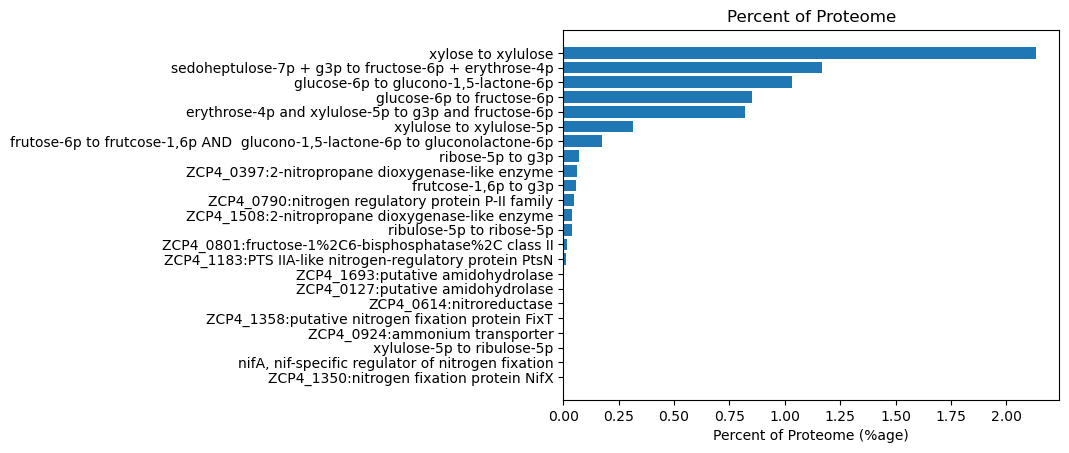

In [42]:
# let's make a protein concentration measurement
group = []
indices = []
for gene in plot_genes:
    gene_changes = gene_changes_df.loc[gene]
    if gene in conversion:
        prot_changes = proteomics_df.rename(columns = conversion_2).loc[conversion[gene]]
    else:
        ZM_gene = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
        prot_changes = proteomics_df.rename(columns = conversion_2).loc[ZM_gene]
    if gene in gene_to_label:
        label = gene_to_label[gene]
    else:
        label = gene+':\n'+ica_data.gene_table.loc[gene].gene_product
    group.append(prot_changes)
    indices.append(label.replace('\n', ''))

a = pd.DataFrame(group)
a.index = indices
a = a.mean(axis = 1).sort_values()
plt.barh(width = 100*a, y = a.index)
plt.title('Percent of Proteome')
plt.xlabel('Percent of Proteome (%age)')
plt.savefig('../figures/proteome_allocation.pdf', transparent = True)

In [25]:
if gene in conversion:
    prot_changes = prot_changes_df.rename(columns = conversion_2).loc[conversion[gene]]
else:
    ZM_gene = ica_data.gene_table.loc[gene].ZM4_locus.split('_')[1]
    prot_changes = prot_changes_df.rename(columns = conversion_2).loc[ZM_gene]

# checking metabolite concentrations

In [16]:
# metabolites data processing
code_to_df_name = {
    'g6p_c' : 'Glucose 6-phosphate',
    '6pgc_c' : '6-phosphogluconate', 
    'f6p_c' : 'Fructose 6-phosphate',
    'xu5p__D_c' : 'Xylulose 5-phosphate',
    'r5p_c' : 'Ribose 5-phosphate', 
    'ru5p__D_c' : 'Ribulose 5-phosphate',
    's7p_c' : 'Sedoheptulose 7-phosphate',
    'e4p_c' : 'Erythrose 4-phosphate',
    'g3p_c' : 'Glycerol 3-phosphate', 
}
external = [
    'Glucose',
    'Xylose',
    'Xylulose',
    'Intracellular Glutamine',
    'Extracellular Glutamine',
    'α-Ketoglutarate', # aka oxoglutarate
    'Intracellular Glutamic Acid', # anion of glutamate
    'Extracellular Glutamic Acid', #  anion of glutamate
]
LDI_samples = [
    'LDI_early_glucose', 'LDI_late_glucose', 
    'LDI_early_xylose', 'LDI_late_xylose', 
]
no_LDI_samples = [
    'no_LDI_early_glucose', 'no_LDI_late_glucose', 
    'no_LDI_early_xylose', 'no_LDI_late_xylose'
]

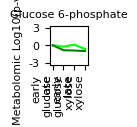

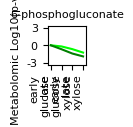

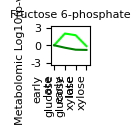

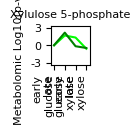

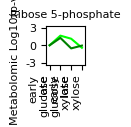

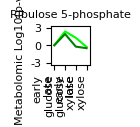

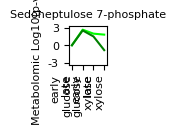

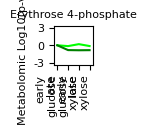

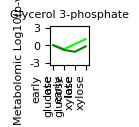

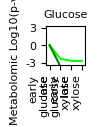

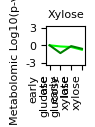

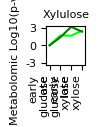

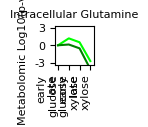

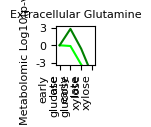

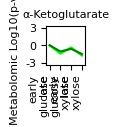

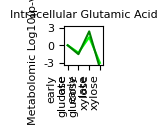

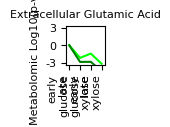

In [17]:
# plotting metabolites
metab_changes_df = flipped_metab_p_value_df # metab_fold_change_df

# firt set bounds
max_y = 0
min_y = 0
min_min_y = -3
max_max_y = 3
selection = metabs+external
for metab in selection:
    max_val = max(metab_changes_df.loc[metab][LDI_samples+no_LDI_samples])
    min_val = min(metab_changes_df.loc[metab][LDI_samples+no_LDI_samples])
    if max_val > max_y:
        max_y = max_val
    if min_val < min_y:
        min_y = min_val
if min_y < min_min_y:
    min_y = min_min_y
if max_y > max_max_y:
    max_y = max_max_y
if abs(max_y) < abs(min_y):
    tick_dist = int(max_y)
else:
    tick_dist = int(min_y)

# now do the plotting
for metab in selection:
    fig, ax = plt.subplots(figsize = (.5, .5))
    ax.plot([0, 1, 2, 3], metab_changes_df.loc[metab][LDI_samples], c = 'lime')
    ax.plot([0, 1, 2, 3], metab_changes_df.loc[metab][no_LDI_samples], c = 'green')
    #ax.scatter([0], [0], c = 'black', marker = 'x', lw = 2, s = 100)
    ax.set_xticks([0, 1, 2, 3], labels = ['early\nglucose', 'late\nglucose', 'early\nxylose', 'late\nxylose'], fontsize = 8, ha = 'right', rotation = 90)
    ax.set_title(metab, fontsize = 8)
    ax.set_xlim([-.3, 3.3])
    ax.set_ylim([1.1*min_y, 1.1*max_y])
    ax.set_yticks([-tick_dist, 0, tick_dist], labels = [-tick_dist, 0, tick_dist], fontsize=8)
    ax.set_ylabel('Metabolomic Log10(p-value)', fontsize = 8)
    plt.savefig('../figures/metab_changes_'+metab+'.pdf', transparent = True)
    plt.show()

# running BLAST to look for ncRNA

In [104]:
import re

def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        header = None
        sequence = []
        
        for line in infile:
            line = line.strip()  # Strip leading/trailing whitespace
            if line.startswith(">"):  # This is a header line
                if header:  # Write the previous sequence if exists
                    outfile.write(header + "\n")
                    outfile.write("".join(sequence) + "\n")
                header = line  # Update the header
                sequence = []  # Reset sequence
            else:
                # Remove any characters that are not A, T, C, G, N, or valid line breaks
                cleaned_line = re.sub(r"[^ATCGNatcg]", "", line)
                sequence.append(cleaned_line)
        
        # Write the last sequence after reading the file
        if header:
            outfile.write(header + "\n")
            outfile.write("".join(sequence) + "\n")

input_file = '../Zymomonas_mobilis/2032_files_sRNA_included/sRNA_genome.fasta'
output_file = '../Zymomonas_mobilis/2032_files_sRNA_included/sRNA_genome_clean.fasta'
clean_fasta(input_file, output_file)
